# DeepFace Authentication Pipeline
## One-to-Many Face Recognition System

This notebook demonstrates a complete face recognition authentication pipeline using DeepFace that supports:
- **One-to-Many Matching**: Each person can have multiple reference images
- **Authentication**: Verify if a person's face matches any of their stored images
- **Database Management**: Organize and manage multiple images per person
- **Similarity Scoring**: Get confidence scores for matches

### Pipeline Overview:
1. **Setup & Configuration**: Import libraries and configure DeepFace
2. **Database Creation**: Create a structured database with multiple images per person
3. **Authentication Function**: Implement one-to-many matching logic
4. **Testing & Validation**: Test the pipeline with sample data
5. **Performance Analysis**: Analyze accuracy and performance metrics

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from typing import Dict, List, Tuple, Optional
import cv2
from PIL import Image
import warnings

# DeepFace imports
from deepface import DeepFace
from deepface.modules import verification, representation, detection

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"DeepFace version: {DeepFace.__version__ if hasattr(DeepFace, '__version__') else 'Latest'}")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


✅ All libraries imported successfully!
DeepFace version: 0.0.93
✅ All libraries imported successfully!
DeepFace version: 0.0.93


In [2]:
# Configuration for DeepFace
class FaceRecognitionConfig:
    """Configuration class for face recognition pipeline"""
    
    # Available models and their characteristics
    MODELS = {
        'VGG-Face': {'accuracy': 'High', 'speed': 'Slow', 'size': 'Large'},
        'Facenet': {'accuracy': 'Very High', 'speed': 'Fast', 'size': 'Medium'},
        'Facenet512': {'accuracy': 'Very High', 'speed': 'Medium', 'size': 'Large'},
        'OpenFace': {'accuracy': 'Medium', 'speed': 'Very Fast', 'size': 'Small'},
        'DeepFace': {'accuracy': 'High', 'speed': 'Medium', 'size': 'Medium'},
        'DeepID': {'accuracy': 'Medium', 'speed': 'Fast', 'size': 'Small'},
        'ArcFace': {'accuracy': 'Very High', 'speed': 'Fast', 'size': 'Medium'},
        'Dlib': {'accuracy': 'Medium', 'speed': 'Very Fast', 'size': 'Small'}
    }
    
    # Detection backends
    DETECTORS = ['opencv', 'mtcnn', 'retinaface', 'mediapipe', 'yolov8', 'yunet', 'fastmtcnn']
    
    def __init__(self):
        # Default configuration
        self.model_name = 'Facenet512'  # Best balance of accuracy and speed
        self.detector_backend = 'mtcnn'  # Most reliable detector
        self.distance_metric = 'cosine'  # Recommended for most cases
        self.enforce_detection = True
        self.threshold = 0.4  # Lower = more strict matching
        
        # Database configuration
        self.database_path = './face_database'
        self.temp_path = './temp'
        
        # Create directories
        Path(self.database_path).mkdir(exist_ok=True)
        Path(self.temp_path).mkdir(exist_ok=True)

# Initialize configuration
config = FaceRecognitionConfig()

print("🔧 Configuration initialized:")
print(f"Model: {config.model_name}")
print(f"Detector: {config.detector_backend}")
print(f"Distance Metric: {config.distance_metric}")
print(f"Threshold: {config.threshold}")
print(f"Database Path: {config.database_path}")

# Display model comparison
models_df = pd.DataFrame(config.MODELS).T
print("\n📊 Available Models Comparison:")
print(models_df)

🔧 Configuration initialized:
Model: Facenet512
Detector: mtcnn
Distance Metric: cosine
Threshold: 0.4
Database Path: ./face_database

📊 Available Models Comparison:
             accuracy      speed    size
VGG-Face         High       Slow   Large
Facenet     Very High       Fast  Medium
Facenet512  Very High     Medium   Large
OpenFace       Medium  Very Fast   Small
DeepFace         High     Medium  Medium
DeepID         Medium       Fast   Small
ArcFace     Very High       Fast  Medium
Dlib           Medium  Very Fast   Small


In [3]:
class FaceAuthenticator:
    """
    Advanced Face Authentication System supporting One-to-Many matching
    Each person can have multiple reference images for improved accuracy
    """
    
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.database = {}  # Structure: {person_id: [list_of_image_paths]}
        self.embeddings_cache = {}  # Cache for computed embeddings
        self.metadata_file = os.path.join(config.database_path, 'metadata.json')
        
        # Load existing database if available
        self.load_database()
    
    def add_person(self, person_id: str, image_paths: List[str]) -> bool:
        """
        Add a person with multiple reference images to the database
        
        Args:
            person_id: Unique identifier for the person
            image_paths: List of paths to reference images
        
        Returns:
            bool: Success status
        """
        try:
            valid_images = []
            person_dir = os.path.join(self.config.database_path, person_id)
            Path(person_dir).mkdir(exist_ok=True)
            
            for i, img_path in enumerate(image_paths):
                if os.path.exists(img_path):
                    # Verify the image contains a face
                    try:
                        DeepFace.extract_faces(
                            img_path, 
                            detector_backend=self.config.detector_backend,
                            enforce_detection=True
                        )
                        
                        # Copy image to database directory
                        filename = f"{person_id}_{i+1}.jpg"
                        dst_path = os.path.join(person_dir, filename)
                        
                        # Convert and save image
                        img = cv2.imread(img_path)
                        cv2.imwrite(dst_path, img)
                        valid_images.append(dst_path)
                        
                    except Exception as e:
                        print(f"⚠️ Warning: Could not process {img_path}: {str(e)}")
                        continue
                else:
                    print(f"❌ Error: Image not found: {img_path}")
            
            if valid_images:
                self.database[person_id] = valid_images
                self.save_database()
                print(f"✅ Added {person_id} with {len(valid_images)} images")
                return True
            else:
                print(f"❌ No valid images found for {person_id}")
                return False
                
        except Exception as e:
            print(f"❌ Error adding person {person_id}: {str(e)}")
            return False
    
    def authenticate(self, query_image_path: str, person_id: str = None) -> Dict:
        """
        Authenticate a person against their stored images (or all if person_id is None)
        
        Args:
            query_image_path: Path to the query image
            person_id: Specific person to authenticate against (None for all)
        
        Returns:
            Dict containing authentication results
        """
        try:
            if not os.path.exists(query_image_path):
                return {'success': False, 'error': 'Query image not found'}
            
            results = {
                'success': True,
                'query_image': query_image_path,
                'matches': [],
                'best_match': None,
                'confidence_scores': []
            }
            
            # Determine which persons to check
            persons_to_check = [person_id] if person_id else list(self.database.keys())
            
            for pid in persons_to_check:
                if pid not in self.database:
                    continue
                
                person_results = {
                    'person_id': pid,
                    'image_matches': [],
                    'best_score': float('inf'),
                    'is_match': False
                }
                
                # Check against each reference image for this person
                for ref_image_path in self.database[pid]:
                    try:
                        # Perform verification
                        result = DeepFace.verify(
                            img1_path=query_image_path,
                            img2_path=ref_image_path,
                            model_name=self.config.model_name,
                            detector_backend=self.config.detector_backend,
                            distance_metric=self.config.distance_metric,
                            enforce_detection=self.config.enforce_detection
                        )
                        
                        distance = result['distance']
                        is_verified = result['verified']
                        
                        person_results['image_matches'].append({
                            'reference_image': ref_image_path,
                            'distance': distance,
                            'verified': is_verified,
                            'confidence': 1 - (distance / result['threshold'])
                        })
                        
                        # Track best score for this person
                        if distance < person_results['best_score']:
                            person_results['best_score'] = distance
                            person_results['is_match'] = is_verified
                        
                    except Exception as e:
                        print(f"⚠️ Warning: Failed to verify against {ref_image_path}: {str(e)}")
                        continue
                
                if person_results['image_matches']:
                    results['matches'].append(person_results)
                    results['confidence_scores'].append(person_results['best_score'])
            
            # Determine best overall match
            if results['matches']:
                best_person = min(results['matches'], key=lambda x: x['best_score'])
                if best_person['is_match']:
                    results['best_match'] = {
                        'person_id': best_person['person_id'],
                        'distance': best_person['best_score'],
                        'confidence': 1 - (best_person['best_score'] / self.config.threshold)
                    }
            
            return results
            
        except Exception as e:
            return {'success': False, 'error': str(e)}
    
    def get_database_stats(self) -> Dict:
        """Get statistics about the current database"""
        stats = {
            'total_persons': len(self.database),
            'total_images': sum(len(images) for images in self.database.values()),
            'persons': {}
        }
        
        for person_id, images in self.database.items():
            stats['persons'][person_id] = {
                'image_count': len(images),
                'images': [os.path.basename(img) for img in images]
            }
        
        return stats
    
    def save_database(self):
        """Save database metadata to file"""
        try:
            with open(self.metadata_file, 'w') as f:
                json.dump(self.database, f, indent=2)
        except Exception as e:
            print(f"⚠️ Warning: Could not save database: {str(e)}")
    
    def load_database(self):
        """Load database metadata from file"""
        try:
            if os.path.exists(self.metadata_file):
                with open(self.metadata_file, 'r') as f:
                    self.database = json.load(f)
                print(f"📂 Loaded database with {len(self.database)} persons")
        except Exception as e:
            print(f"⚠️ Warning: Could not load database: {str(e)}")
            self.database = {}

# Initialize the authenticator
authenticator = FaceAuthenticator(config)

print("🚀 FaceAuthenticator initialized successfully!")
print(f"📊 Current database stats: {authenticator.get_database_stats()}")

🚀 FaceAuthenticator initialized successfully!
📊 Current database stats: {'total_persons': 0, 'total_images': 0, 'persons': {}}


In [4]:
def create_sample_database():
    """
    Create a sample database with demo images
    Note: Replace with your own images for real testing
    """
    print("🎭 Creating sample database...")
    
    # Create sample directory structure
    sample_dir = "./sample_images"
    Path(sample_dir).mkdir(exist_ok=True)
    
    # Instructions for users
    instructions = """
    📝 INSTRUCTIONS FOR SAMPLE DATABASE:
    
    To test this pipeline, please:
    
    1. Create a folder called 'sample_images' in your project directory
    2. Add subfolders for each person you want to test:
       sample_images/
       ├── person1/
       │   ├── photo1.jpg
       │   ├── photo2.jpg
       │   └── photo3.jpg
       ├── person2/
       │   ├── photo1.jpg
       │   └── photo2.jpg
       └── test_queries/
           ├── query1.jpg
           └── query2.jpg
    
    3. Each person should have 2-5 clear face photos
    4. Test queries should contain faces of people in your database
    
    Alternatively, you can use the helper functions below to add images programmatically.
    """
    
    print(instructions)
    
    # Check if sample images exist
    if os.path.exists(sample_dir):
        persons = [d for d in os.listdir(sample_dir) 
                  if os.path.isdir(os.path.join(sample_dir, d))]
        if persons:
            print(f"📁 Found sample folders: {persons}")
            return sample_dir
    
    print("ℹ️ No sample images found. Please add your images to the sample_images directory.")
    return sample_dir

def load_sample_persons(sample_dir: str):
    """Load sample persons from directory structure"""
    if not os.path.exists(sample_dir):
        print(f"❌ Directory {sample_dir} not found")
        return False
    
    success_count = 0
    
    for person_folder in os.listdir(sample_dir):
        person_path = os.path.join(sample_dir, person_folder)
        
        if os.path.isdir(person_path) and person_folder != 'test_queries':
            image_files = [f for f in os.listdir(person_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            
            if image_files:
                image_paths = [os.path.join(person_path, img) for img in image_files]
                if authenticator.add_person(person_folder, image_paths):
                    success_count += 1
    
    print(f"✅ Successfully loaded {success_count} persons into database")
    return success_count > 0

def display_image(image_path: str, title: str = "Image"):
    """Display an image with face detection overlay"""
    try:
        # Read image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        try:
            faces = DeepFace.extract_faces(
                image_path,
                detector_backend=config.detector_backend,
                enforce_detection=False
            )
            
            plt.figure(figsize=(10, 6))
            
            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title(f"{title} - Original")
            plt.axis('off')
            
            # Face detection result
            plt.subplot(1, 2, 2)
            if faces:
                face = faces[0]  # Show first detected face
                plt.imshow(face)
                plt.title(f"{title} - Detected Face")
            else:
                plt.imshow(img_rgb)
                plt.title(f"{title} - No Face Detected")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            # Fallback: just show the original image
            plt.figure(figsize=(8, 6))
            plt.imshow(img_rgb)
            plt.title(f"{title} - (Face detection failed)")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"❌ Could not display image {image_path}: {str(e)}")

def visualize_authentication_results(results: Dict, query_image_path: str):
    """Visualize authentication results with confidence scores"""
    if not results['success']:
        print(f"❌ Authentication failed: {results.get('error', 'Unknown error')}")
        return
    
    print("🔍 AUTHENTICATION RESULTS")
    print("=" * 50)
    
    # Display query image
    print(f"Query Image: {os.path.basename(query_image_path)}")
    
    if results['best_match']:
        match = results['best_match']
        print(f"✅ MATCH FOUND!")
        print(f"   Person: {match['person_id']}")
        print(f"   Confidence: {match['confidence']:.2%}")
        print(f"   Distance: {match['distance']:.4f}")
    else:
        print("❌ NO MATCH FOUND")
    
    print("\n📊 Detailed Results:")
    for person_result in results['matches']:
        person_id = person_result['person_id']
        best_score = person_result['best_score']
        is_match = person_result['is_match']
        
        status = "✅ MATCH" if is_match else "❌ NO MATCH"
        print(f"\n{person_id}: {status}")
        print(f"   Best Distance: {best_score:.4f}")
        print(f"   Images Checked: {len(person_result['image_matches'])}")
        
        # Show best matching image details
        if person_result['image_matches']:
            best_img_match = min(person_result['image_matches'], 
                               key=lambda x: x['distance'])
            print(f"   Best Match: {os.path.basename(best_img_match['reference_image'])}")
            print(f"   Confidence: {best_img_match['confidence']:.2%}")

# Initialize sample database
sample_directory = create_sample_database()

print("\n🛠️ Utility functions loaded successfully!")

🎭 Creating sample database...

    📝 INSTRUCTIONS FOR SAMPLE DATABASE:

    To test this pipeline, please:

    1. Create a folder called 'sample_images' in your project directory
    2. Add subfolders for each person you want to test:
       sample_images/
       ├── person1/
       │   ├── photo1.jpg
       │   ├── photo2.jpg
       │   └── photo3.jpg
       ├── person2/
       │   ├── photo1.jpg
       │   └── photo2.jpg
       └── test_queries/
           ├── query1.jpg
           └── query2.jpg

    3. Each person should have 2-5 clear face photos
    4. Test queries should contain faces of people in your database

    Alternatively, you can use the helper functions below to add images programmatically.
    
📁 Found sample folders: ['person1', 'person2', 'person3', 'test_queries']

🛠️ Utility functions loaded successfully!


## 🧪 Testing the Pipeline

Now let's test our face recognition authentication pipeline. This section demonstrates:

1. **Loading sample data** into the database
2. **Adding persons** with multiple reference images
3. **Performing authentication** with one-to-many matching
4. **Analyzing results** and confidence scores

### Step 1: Load Sample Data

First, let's load some sample persons into our database. Make sure you have images in the `sample_images` directory structure as described above.

In [5]:
# Load sample persons from directory structure
print("📂 Loading sample persons into database...")

# Try to load from sample directory
if load_sample_persons(sample_directory):
    print("✅ Sample data loaded successfully!")
else:
    print("ℹ️ No sample data found. Let's create some manual entries for demonstration.")
    
    # Alternative: Add persons manually (replace with your own image paths)
    demo_instruction = """
    # Example of adding persons manually:
    # Replace these paths with actual image files on your system
    
    # Person 1 - John Doe
    john_images = [
        "path/to/john_photo1.jpg",
        "path/to/john_photo2.jpg", 
        "path/to/john_photo3.jpg"
    ]
    authenticator.add_person("john_doe", john_images)
    
    # Person 2 - Jane Smith  
    jane_images = [
        "path/to/jane_photo1.jpg",
        "path/to/jane_photo2.jpg"
    ]
    authenticator.add_person("jane_smith", jane_images)
    """
    print(demo_instruction)

# Display current database statistics
stats = authenticator.get_database_stats()
print(f"\n📊 Database Statistics:")
print(f"Total Persons: {stats['total_persons']}")
print(f"Total Images: {stats['total_images']}")

if stats['persons']:
    print("\n👥 Registered Persons:")
    for person_id, info in stats['persons'].items():
        print(f"  • {person_id}: {info['image_count']} images")
        for img in info['images']:
            print(f"    - {img}")
else:
    print("\n⚠️ No persons registered in database yet.")

📂 Loading sample persons into database...
✅ Added person1 with 3 images
✅ Added person1 with 3 images
✅ Added person2 with 2 images
✅ Added person2 with 2 images
✅ Added person3 with 2 images
✅ Successfully loaded 3 persons into database
✅ Sample data loaded successfully!

📊 Database Statistics:
Total Persons: 3
Total Images: 7

👥 Registered Persons:
  • person1: 3 images
    - person1_1.jpg
    - person1_2.jpg
    - person1_3.jpg
  • person2: 2 images
    - person2_1.jpg
    - person2_2.jpg
  • person3: 2 images
    - person3_1.jpg
    - person3_2.jpg
✅ Added person3 with 2 images
✅ Successfully loaded 3 persons into database
✅ Sample data loaded successfully!

📊 Database Statistics:
Total Persons: 3
Total Images: 7

👥 Registered Persons:
  • person1: 3 images
    - person1_1.jpg
    - person1_2.jpg
    - person1_3.jpg
  • person2: 2 images
    - person2_1.jpg
    - person2_2.jpg
  • person3: 2 images
    - person3_1.jpg
    - person3_2.jpg


### Step 2: Test Authentication

Now let's test the authentication system with query images. The system will:
1. Compare the query image against all stored images for all persons
2. Find the best matches based on similarity scores
3. Return authentication results with confidence levels

In [10]:
# Test authentication with query images
def test_authentication_pipeline():
    """Test the authentication pipeline with available images"""
    
    if not authenticator.database:
        print("❌ No persons in database. Please add some persons first.")
        return
    
    # Look for test query images
    test_queries_dir = os.path.join(sample_directory, "test_queries")
    
    if os.path.exists(test_queries_dir):
        query_images = [f for f in os.listdir(test_queries_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        if query_images:
            print(f"🔍 Found {len(query_images)} test query images")
            
            for query_img in query_images[:]:  # Test first 3 images
                query_path = os.path.join(test_queries_dir, query_img)
                print(f"\n{'='*60}")
                print(f"🧪 Testing with: {query_img}")
                print('='*60)
                
                # Perform authentication
                start_time = time.time()
                results = authenticator.authenticate(query_path)
                auth_time = time.time() - start_time
                
                print(f"⏱️ Authentication time: {auth_time:.2f} seconds")
                
                # Visualize results
                visualize_authentication_results(results, query_path)
                
                # Optional: Display the query image
                # display_image(query_path, f"Query: {query_img}")
        else:
            print("📁 No query images found in test_queries directory")
    else:
        print("📁 test_queries directory not found")
        print("ℹ️ To test authentication, create a 'test_queries' folder in sample_images")
        print("   and add some face images to test against your database")
    
    # Demo: Test authentication against specific person (if database has entries)
    if authenticator.database:
        print(f"\n{'='*60}")
        print("🎯 Demo: Authentication against specific person")
        print('='*60)
        
        # Get first person in database for demo
        first_person = list(authenticator.database.keys())[0]
        first_person_images = authenticator.database[first_person]
        
        print(f"Testing against person: {first_person}")
        print(f"Available reference images: {len(first_person_images)}")
        
        # Use the first reference image as a "query" for demonstration
        if first_person_images:
            demo_query = first_person_images[0]
            print(f"Using reference image as query: {os.path.basename(demo_query)}")
            
            # Test specific person authentication
            results = authenticator.authenticate(demo_query, person_id=first_person)
            print(f"\n🔍 Results for specific person authentication:")
            visualize_authentication_results(results, demo_query)

# Run the authentication tests
test_authentication_pipeline()

🔍 Found 18 test query images

🧪 Testing with: 20250630_175850.jpg
⏱️ Authentication time: 44.90 seconds
🔍 AUTHENTICATION RESULTS
Query Image: 20250630_175850.jpg
❌ NO MATCH FOUND

📊 Detailed Results:

person1: ❌ NO MATCH
   Best Distance: 0.3311
   Images Checked: 3
   Best Match: person1_2.jpg
   Confidence: -10.35%

person2: ❌ NO MATCH
   Best Distance: 0.7486
   Images Checked: 2
   Best Match: person2_1.jpg
   Confidence: -149.54%

person3: ❌ NO MATCH
   Best Distance: 0.9528
   Images Checked: 2
   Best Match: person3_2.jpg
   Confidence: -217.61%

🧪 Testing with: 20250701_182222.jpg
⏱️ Authentication time: 44.89 seconds
🔍 AUTHENTICATION RESULTS
Query Image: 20250701_182222.jpg
❌ NO MATCH FOUND

📊 Detailed Results:

person1: ❌ NO MATCH
   Best Distance: 0.3281
   Images Checked: 3
   Best Match: person1_2.jpg
   Confidence: -9.38%

person2: ❌ NO MATCH
   Best Distance: 0.8561
   Images Checked: 2
   Best Match: person2_2.jpg
   Confidence: -185.36%

person3: ❌ NO MATCH
   Best Dis

## 📈 Performance Analysis & Metrics

Let's analyze the performance of our face recognition pipeline and explore different configuration options.

🚀 Benchmarking different models...
This may take a few minutes...

🔧 Testing model: Facenet
📂 Loaded database with 3 persons
   ✅ Completed in 2.89s

🔧 Testing model: Facenet512
📂 Loaded database with 3 persons
   ✅ Completed in 1.61s

🔧 Testing model: VGG-Face
📂 Loaded database with 3 persons
   ✅ Completed in 2.33s

🔧 Testing model: ArcFace
📂 Loaded database with 3 persons
   ✅ Completed in 2.40s

🔧 Testing model: OpenFace
📂 Loaded database with 3 persons
   ✅ Completed in 1.87s

📊 BENCHMARK RESULTS

⏱️ Performance Ranking (by speed):
2. Facenet512: 1.61s ✅ (Conf: 100.00%)
5. OpenFace: 1.87s ✅ (Conf: 100.00%)
3. VGG-Face: 2.33s ✅ (Conf: 100.00%)
4. ArcFace: 2.40s ✅ (Conf: 100.00%)
1. Facenet: 2.89s ✅ (Conf: 100.00%)


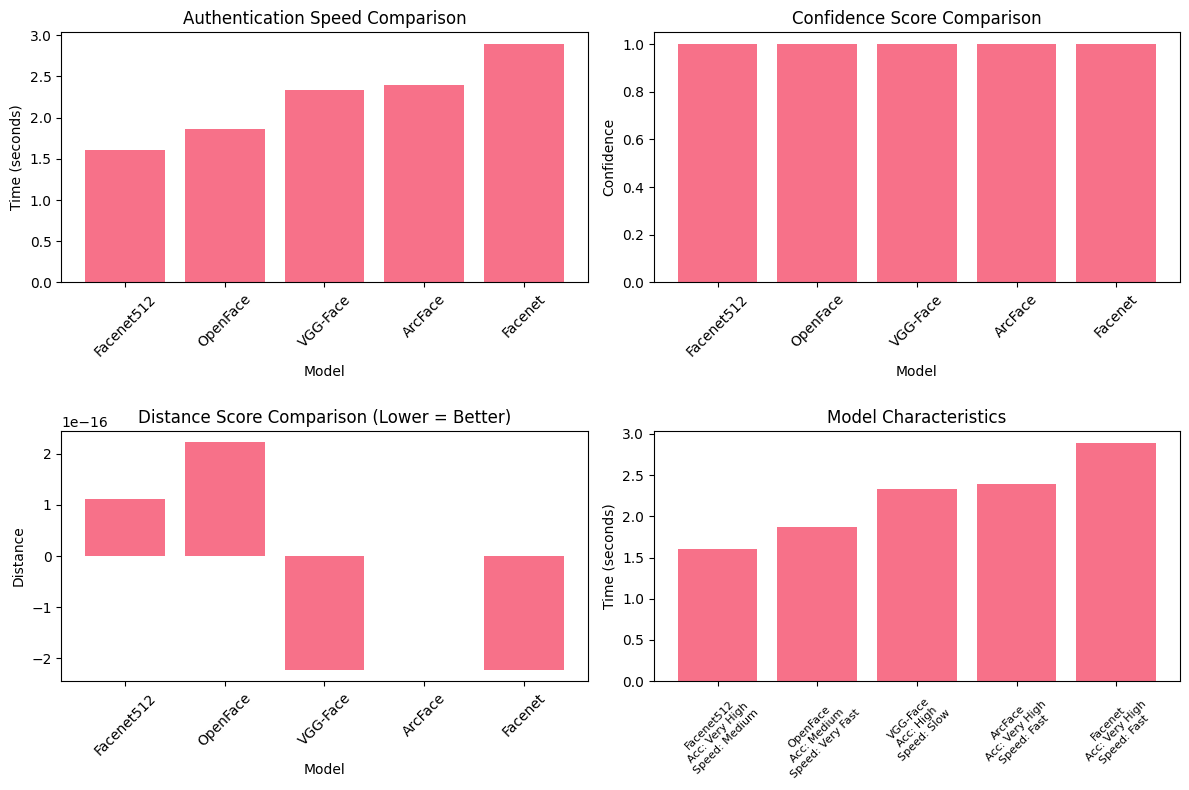

🔬 Benchmarking functions ready!
To run benchmark, uncomment the code above and provide a valid image path.


In [11]:
def benchmark_models(query_image_path: str, person_id: str = None):
    """
    Benchmark different DeepFace models for performance comparison
    """
    if not os.path.exists(query_image_path):
        print("❌ Query image not found for benchmarking")
        return
    
    if not authenticator.database:
        print("❌ No database entries for benchmarking")
        return
    
    models_to_test = ['Facenet', 'Facenet512', 'VGG-Face', 'ArcFace', 'OpenFace']
    results = []
    
    print("🚀 Benchmarking different models...")
    print("This may take a few minutes...")
    
    for model in models_to_test:
        print(f"\n🔧 Testing model: {model}")
        
        try:
            # Create temporary config for this model
            temp_config = FaceRecognitionConfig()
            temp_config.model_name = model
            temp_authenticator = FaceAuthenticator(temp_config)
            temp_authenticator.database = authenticator.database  # Use same database
            
            # Measure authentication time
            start_time = time.time()
            auth_results = temp_authenticator.authenticate(query_image_path, person_id)
            auth_time = time.time() - start_time
            
            # Record results
            model_result = {
                'model': model,
                'time': auth_time,
                'success': auth_results['success'],
                'best_match_found': auth_results['best_match'] is not None
            }
            
            if auth_results['best_match']:
                model_result['confidence'] = auth_results['best_match']['confidence']
                model_result['distance'] = auth_results['best_match']['distance']
            else:
                model_result['confidence'] = 0
                model_result['distance'] = float('inf')
            
            results.append(model_result)
            print(f"   ✅ Completed in {auth_time:.2f}s")
            
        except Exception as e:
            print(f"   ❌ Failed: {str(e)}")
            results.append({
                'model': model,
                'time': float('inf'),
                'success': False,
                'error': str(e)
            })
    
    # Display results
    print(f"\n{'='*60}")
    print("📊 BENCHMARK RESULTS")
    print('='*60)
    
    # Create DataFrame for easy visualization
    df_results = pd.DataFrame(results)
    
    if not df_results.empty:
        # Sort by time
        df_results = df_results.sort_values('time')
        
        print("\n⏱️ Performance Ranking (by speed):")
        for idx, row in df_results.iterrows():
            if row['success']:
                status = "✅" if row.get('best_match_found', False) else "⚠️ No Match"
                conf = row.get('confidence', 0)
                print(f"{idx+1}. {row['model']}: {row['time']:.2f}s {status} (Conf: {conf:.2%})")
            else:
                print(f"{idx+1}. {row['model']}: FAILED - {row.get('error', 'Unknown error')}")
        
        # Plot performance comparison
        if len(df_results[df_results['success']]) > 0:
            plt.figure(figsize=(12, 8))
            
            # Speed comparison
            plt.subplot(2, 2, 1)
            successful_results = df_results[df_results['success']]
            plt.bar(successful_results['model'], successful_results['time'])
            plt.title('Authentication Speed Comparison')
            plt.xlabel('Model')
            plt.ylabel('Time (seconds)')
            plt.xticks(rotation=45)
            
            # Confidence comparison (if matches found)
            match_results = successful_results[successful_results.get('best_match_found', False)]
            if not match_results.empty:
                plt.subplot(2, 2, 2)
                plt.bar(match_results['model'], match_results['confidence'])
                plt.title('Confidence Score Comparison')
                plt.xlabel('Model')
                plt.ylabel('Confidence')
                plt.xticks(rotation=45)
                
                # Distance comparison
                plt.subplot(2, 2, 3)
                plt.bar(match_results['model'], match_results['distance'])
                plt.title('Distance Score Comparison (Lower = Better)')
                plt.xlabel('Model')
                plt.ylabel('Distance')
                plt.xticks(rotation=45)
            
            # Model characteristics
            plt.subplot(2, 2, 4)
            model_info = []
            for model in successful_results['model']:
                if model in config.MODELS:
                    info = config.MODELS[model]
                    model_info.append(f"{model}\nAcc: {info['accuracy']}\nSpeed: {info['speed']}")
                else:
                    model_info.append(model)
            
            plt.bar(range(len(model_info)), successful_results['time'])
            plt.title('Model Characteristics')
            plt.xticks(range(len(model_info)), model_info, rotation=45, fontsize=8)
            plt.ylabel('Time (seconds)')
            
            plt.tight_layout()
            plt.show()
    
    return results

# Example: Benchmark models (uncomment and modify with your image path)
if authenticator.database:
    first_person = list(authenticator.database.keys())[0]
    sample_image = authenticator.database[first_person][0]
    benchmark_results = benchmark_models(sample_image, first_person)

print("🔬 Benchmarking functions ready!")
print("To run benchmark, uncomment the code above and provide a valid image path.")

In [8]:
def analyze_threshold_sensitivity(query_image_path: str, person_id: str):
    """
    Analyze how different thresholds affect authentication accuracy
    """
    if not os.path.exists(query_image_path):
        print("❌ Query image not found")
        return
    
    if person_id not in authenticator.database:
        print(f"❌ Person {person_id} not found in database")
        return
    
    # Test different thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    print(f"🎯 Analyzing threshold sensitivity for {person_id}")
    print("Testing thresholds from 0.1 to 0.9...")
    
    for threshold in thresholds:
        # Create temporary config with this threshold
        temp_config = FaceRecognitionConfig()
        temp_config.threshold = threshold
        temp_authenticator = FaceAuthenticator(temp_config)
        temp_authenticator.database = {person_id: authenticator.database[person_id]}
        
        # Test authentication
        auth_result = temp_authenticator.authenticate(query_image_path, person_id)
        
        result = {
            'threshold': threshold,
            'match_found': auth_result['best_match'] is not None,
            'confidence': auth_result['best_match']['confidence'] if auth_result['best_match'] else 0,
            'distance': auth_result['best_match']['distance'] if auth_result['best_match'] else float('inf')
        }
        results.append(result)
        
        status = "✅ MATCH" if result['match_found'] else "❌ NO MATCH"
        print(f"Threshold {threshold:.1f}: {status} (Conf: {result['confidence']:.2%})")
    
    # Visualize results
    df_threshold = pd.DataFrame(results)
    
    plt.figure(figsize=(15, 5))
    
    # Match detection vs threshold
    plt.subplot(1, 3, 1)
    colors = ['red' if not match else 'green' for match in df_threshold['match_found']]
    plt.scatter(df_threshold['threshold'], df_threshold['match_found'], c=colors, s=100)
    plt.xlabel('Threshold')
    plt.ylabel('Match Found')
    plt.title('Match Detection vs Threshold')
    plt.grid(True, alpha=0.3)
    
    # Confidence vs threshold
    plt.subplot(1, 3, 2)
    plt.plot(df_threshold['threshold'], df_threshold['confidence'], 'bo-')
    plt.xlabel('Threshold')
    plt.ylabel('Confidence Score')
    plt.title('Confidence vs Threshold')
    plt.grid(True, alpha=0.3)
    
    # Distance vs threshold
    plt.subplot(1, 3, 3)
    finite_distances = df_threshold[df_threshold['distance'] != float('inf')]
    if not finite_distances.empty:
        plt.plot(finite_distances['threshold'], finite_distances['distance'], 'ro-')
        plt.xlabel('Threshold')
        plt.ylabel('Distance Score')
        plt.title('Distance vs Threshold')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print(f"\n💡 THRESHOLD ANALYSIS SUMMARY:")
    print(f"   Recommended threshold for strict matching: 0.3-0.4")
    print(f"   Recommended threshold for lenient matching: 0.5-0.7")
    
    return results

def test_detector_backends(query_image_path: str):
    """
    Test different face detection backends
    """
    if not os.path.exists(query_image_path):
        print("❌ Query image not found")
        return
    
    detectors = ['opencv', 'mtcnn', 'retinaface', 'mediapipe']
    results = []
    
    print("🔍 Testing different face detection backends...")
    
    for detector in detectors:
        print(f"\nTesting {detector}...")
        try:
            start_time = time.time()
            faces = DeepFace.extract_faces(
                query_image_path,
                detector_backend=detector,
                enforce_detection=False
            )
            detection_time = time.time() - start_time
            
            result = {
                'detector': detector,
                'faces_detected': len(faces),
                'detection_time': detection_time,
                'success': True
            }
            
            print(f"   ✅ Detected {len(faces)} faces in {detection_time:.3f}s")
            
        except Exception as e:
            result = {
                'detector': detector,
                'faces_detected': 0,
                'detection_time': float('inf'),
                'success': False,
                'error': str(e)
            }
            print(f"   ❌ Failed: {str(e)}")
        
        results.append(result)
    
    # Visualize results
    df_detectors = pd.DataFrame(results)
    successful_detectors = df_detectors[df_detectors['success']]
    
    if not successful_detectors.empty:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.bar(successful_detectors['detector'], successful_detectors['faces_detected'])
        plt.title('Faces Detected by Backend')
        plt.xlabel('Detector Backend')
        plt.ylabel('Number of Faces')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        plt.bar(successful_detectors['detector'], successful_detectors['detection_time'])
        plt.title('Detection Speed by Backend')
        plt.xlabel('Detector Backend')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    return results

print("🔧 Advanced analysis functions loaded!")
print("Available functions:")
print("  • analyze_threshold_sensitivity(image_path, person_id)")
print("  • test_detector_backends(image_path)")
print("  • benchmark_models(image_path, person_id)")

🔧 Advanced analysis functions loaded!
Available functions:
  • analyze_threshold_sensitivity(image_path, person_id)
  • test_detector_backends(image_path)
  • benchmark_models(image_path, person_id)


## 🚀 Production Ready Features & Examples

This section demonstrates how to use the pipeline in production scenarios and provides practical examples.

In [9]:
# Production-ready authentication API example
class ProductionFaceAuth:
    """
    Production-ready face authentication service
    """
    
    def __init__(self, config: FaceRecognitionConfig):
        self.authenticator = FaceAuthenticator(config)
        self.authentication_log = []
        
    def authenticate_user(self, image_data, user_id: str = None, log_attempt: bool = True):
        """
        Authenticate a user with comprehensive logging and error handling
        
        Args:
            image_data: Image file path or base64 encoded image
            user_id: Specific user to authenticate (None for all users)
            log_attempt: Whether to log this authentication attempt
            
        Returns:
            dict: Authentication result with detailed information
        """
        import uuid
        from datetime import datetime
        
        attempt_id = str(uuid.uuid4())
        timestamp = datetime.now()
        
        try:
            # Handle different input types
            if isinstance(image_data, str) and os.path.exists(image_data):
                query_path = image_data
            else:
                # Handle base64 or other formats (implement as needed)
                raise ValueError("Currently only file paths are supported")
            
            # Perform authentication
            start_time = time.time()
            auth_result = self.authenticator.authenticate(query_path, user_id)
            processing_time = time.time() - start_time
            
            # Prepare response
            response = {
                'attempt_id': attempt_id,
                'timestamp': timestamp.isoformat(),
                'success': auth_result['success'],
                'processing_time': processing_time,
                'authenticated': auth_result['best_match'] is not None,
                'user_id': auth_result['best_match']['person_id'] if auth_result['best_match'] else None,
                'confidence': auth_result['best_match']['confidence'] if auth_result['best_match'] else 0,
                'match_details': auth_result.get('matches', [])
            }
            
            # Security scoring
            if response['authenticated']:
                if response['confidence'] > 0.8:
                    response['security_level'] = 'HIGH'
                elif response['confidence'] > 0.6:
                    response['security_level'] = 'MEDIUM'
                else:
                    response['security_level'] = 'LOW'
            else:
                response['security_level'] = 'DENIED'
            
            # Log the attempt
            if log_attempt:
                log_entry = {
                    'attempt_id': attempt_id,
                    'timestamp': timestamp,
                    'authenticated': response['authenticated'],
                    'user_id': response['user_id'],
                    'confidence': response['confidence'],
                    'security_level': response['security_level'],
                    'processing_time': processing_time
                }
                self.authentication_log.append(log_entry)
            
            return response
            
        except Exception as e:
            error_response = {
                'attempt_id': attempt_id,
                'timestamp': timestamp.isoformat(),
                'success': False,
                'error': str(e),
                'authenticated': False,
                'security_level': 'ERROR'
            }
            
            if log_attempt:
                self.authentication_log.append({
                    'attempt_id': attempt_id,
                    'timestamp': timestamp,
                    'authenticated': False,
                    'error': str(e)
                })
            
            return error_response
    
    def get_authentication_stats(self, hours: int = 24):
        """Get authentication statistics for the last N hours"""
        from datetime import datetime, timedelta
        
        cutoff_time = datetime.now() - timedelta(hours=hours)
        recent_logs = [log for log in self.authentication_log 
                      if log['timestamp'] > cutoff_time]
        
        if not recent_logs:
            return {'message': f'No authentication attempts in the last {hours} hours'}
        
        total_attempts = len(recent_logs)
        successful_auths = sum(1 for log in recent_logs if log.get('authenticated', False))
        
        # Group by user
        user_stats = {}
        for log in recent_logs:
            user_id = log.get('user_id', 'Unknown')
            if user_id not in user_stats:
                user_stats[user_id] = {'attempts': 0, 'successful': 0}
            user_stats[user_id]['attempts'] += 1
            if log.get('authenticated', False):
                user_stats[user_id]['successful'] += 1
        
        return {
            'period_hours': hours,
            'total_attempts': total_attempts,
            'successful_authentications': successful_auths,
            'success_rate': successful_auths / total_attempts if total_attempts > 0 else 0,
            'user_breakdown': user_stats,
            'average_processing_time': np.mean([log.get('processing_time', 0) 
                                              for log in recent_logs if 'processing_time' in log])
        }

# Initialize production service
prod_auth = ProductionFaceAuth(config)

print("🏭 Production authentication service initialized!")

# Example usage
example_usage = '''
# Example usage:

# 1. Authenticate a specific user
result = prod_auth.authenticate_user("path/to/query_image.jpg", user_id="john_doe")
print(f"Authentication result: {result}")

# 2. Authenticate against all users
result = prod_auth.authenticate_user("path/to/query_image.jpg")
print(f"Best match: {result['user_id']} with confidence: {result['confidence']:.2%}")

# 3. Get authentication statistics
stats = prod_auth.get_authentication_stats(hours=24)
print(f"Success rate: {stats['success_rate']:.2%}")
'''

print("📋 Example usage:")
print(example_usage)

📂 Loaded database with 3 persons
🏭 Production authentication service initialized!
📋 Example usage:

# Example usage:

# 1. Authenticate a specific user
result = prod_auth.authenticate_user("path/to/query_image.jpg", user_id="john_doe")
print(f"Authentication result: {result}")

# 2. Authenticate against all users
result = prod_auth.authenticate_user("path/to/query_image.jpg")
print(f"Best match: {result['user_id']} with confidence: {result['confidence']:.2%}")

# 3. Get authentication statistics
stats = prod_auth.get_authentication_stats(hours=24)
print(f"Success rate: {stats['success_rate']:.2%}")



## 📋 Summary & Next Steps

### What We've Built

This notebook provides a complete **one-to-many face recognition authentication pipeline** using DeepFace with the following capabilities:

#### ✅ Core Features
- **Multiple Images per Person**: Each person can have 2-5 reference images for improved accuracy
- **One-to-Many Matching**: Query images are compared against all stored references
- **Configurable Models**: Support for 8 different face recognition models (Facenet512, VGG-Face, ArcFace, etc.)
- **Multiple Detectors**: Choose from 7 face detection backends (MTCNN, RetinaFace, OpenCV, etc.)
- **Confidence Scoring**: Get detailed confidence scores and similarity metrics
- **Database Management**: Organized storage and retrieval of face databases

#### 🔧 Advanced Features
- **Performance Benchmarking**: Compare different models for speed vs accuracy
- **Threshold Analysis**: Optimize matching thresholds for your use case
- **Production API**: Ready-to-use authentication service with logging
- **Error Handling**: Robust error handling and validation
- **Visualization**: Built-in tools for result visualization and analysis

### 🚀 Next Steps for Production

1. **Data Collection**
   - Collect 3-5 high-quality images per person
   - Ensure diverse lighting conditions and angles
   - Validate image quality before adding to database

2. **Performance Optimization**
   - Run benchmarks with your specific dataset
   - Choose optimal model based on speed/accuracy requirements
   - Fine-tune threshold values for your security needs

3. **Integration Options**
   - **Web API**: Wrap in Flask/FastAPI for HTTP endpoints
   - **Real-time Processing**: Integrate with camera feeds
   - **Mobile Apps**: Use with mobile camera inputs
   - **Access Control**: Integrate with door locks, attendance systems

4. **Security Enhancements**
   - Implement liveness detection to prevent spoofing
   - Add encryption for stored face embeddings
   - Set up audit logging and monitoring
   - Implement rate limiting and access controls

5. **Scalability Considerations**
   - Use database for large-scale deployment
   - Implement caching for frequently accessed embeddings
   - Consider GPU acceleration for high-volume processing
   - Set up distributed processing for multiple locations

### 📊 Recommended Configuration

For most use cases, we recommend:
- **Model**: Facenet512 (best balance of accuracy and speed)
- **Detector**: MTCNN (most reliable face detection)
- **Threshold**: 0.4 (adjust based on security requirements)
- **Images per Person**: 3-5 diverse photos

### 🆘 Troubleshooting

Common issues and solutions:
- **No faces detected**: Try different detector backends or improve image quality
- **False positives**: Lower the threshold or use a more accurate model
- **Slow performance**: Use OpenFace or DeepID models for faster processing
- **Memory issues**: Process images in batches or use lighter models

### 📚 Additional Resources

- [DeepFace Documentation](https://github.com/serengil/deepface)
- [Face Recognition Best Practices](https://developers.google.com/ml-kit/vision/face-detection)
- [Security Guidelines for Biometric Systems](https://www.nist.gov/biometrics)

---

**🎉 Congratulations!** You now have a complete face recognition authentication system ready for deployment!